In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [90]:
maxdegree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 1000  # Training and test data set sizes
true_w = nd.zeros(maxdegree)  # Allocate lots of empty space
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)
poly_features = nd.power(features, nd.arange(maxdegree).reshape((1, -1)))
poly_features = poly_features / (
    nd.gamma(nd.arange(maxdegree) + 1).reshape((1, -1)))
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)


[[ 1.0000000e+00  8.9846641e-01  4.0362093e-01  1.2087995e-01]
 [ 1.0000000e+00  1.6373974e+00  1.3405352e+00  7.3166293e-01]
 [ 1.0000000e+00  7.5706534e-02  2.8657396e-03  7.2318406e-05]
 ...
 [ 1.0000000e+00  1.4206151e+00  1.0090736e+00  4.7783506e-01]
 [ 1.0000000e+00 -9.4091696e-01  4.4266236e-01 -1.3883618e-01]
 [ 1.0000000e+00  3.1692132e-02  5.0219562e-04  5.3052167e-06]]
<NDArray 1100x4 @cpu(0)>

In [73]:
# a = nd.dot(poly_features[:,:4], true_w[:4])
# b = nd.dot(poly_features, true_w)
# print(a[:10])
# print(b[:10])


[5.3827763 6.5043697 5.081509  5.6031475 5.1294208 5.3054485 1.6797717
 5.4501653 5.2469983 6.5450077]
<NDArray 10 @cpu(0)>

[5.3827763 6.5043697 5.0815096 5.6031475 5.1294208 5.3054485 1.6797717
 5.4501653 5.2469983 6.545008 ]
<NDArray 10 @cpu(0)>


In [21]:
# This function has been saved in the d2l package for future use
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [27]:
num_epochs, loss = 200, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy())

final epoch: train loss 0.0047998424 test loss 0.005318958
weight: [[ 4.998374   1.2077194 -3.3990602  5.5944047]]


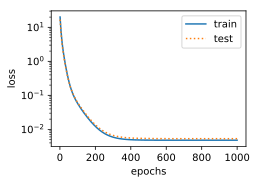

In [89]:
num_epochs = 1000
# Pick the first four dimensions, i.e. 1, x, x^2, x^3 from the polynomial
# features
fit_and_plot(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
             labels[:n_train], labels[n_train:])

final epoch: train loss 6.5729203 test loss 5.5127788
weight: [[3.1559684 4.971088 ]]


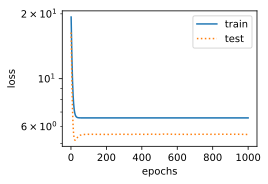

In [35]:
num_epochs = 1000
# Pick the first four dimensions, i.e. 1, x from the polynomial features
fit_and_plot(poly_features[:n_train, 0:2], poly_features[n_train:, 0:2],
             labels[:n_train], labels[n_train:])

final epoch: train loss 0.011150848 test loss 0.0138745215
weight: [[ 4.9437332e+00  1.3174669e+00 -3.2203848e+00  5.0153546e+00
  -3.6229843e-01  1.3918500e+00  6.0386024e-02  2.4691395e-01
   5.5357195e-02  2.3363257e-02 -2.4106685e-02  6.2909931e-02
   2.2134015e-02  8.3888005e-03  2.4300988e-03  9.0535469e-03
  -2.1046887e-03 -6.2836111e-02  5.6162708e-02 -5.5428974e-02]]


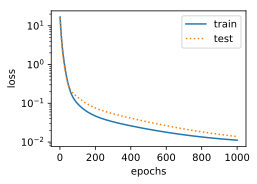

In [91]:
num_epochs = 1000
n_subset = 100  # Subset of data to train on
n_degree = 20   # Degree of polynomials
fit_and_plot(poly_features[1:n_subset, 0:n_degree],
             poly_features[n_train:, 0:n_degree], labels[1:n_subset],
             labels[n_train:])